In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
HLA_associations_path = os.path.abspath("../")
sys.path.append(HLA_associations_path)

import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import constants, index_tools, data_tools, medical_code_tools
from utilities import *
from analysis import *

import sys
sys.path.append(constants.GRANTHAM_DISTANCE_PATH)

import grantham_distance as gd

In [2]:
from tqdm.notebook import tqdm

In [3]:
sns.set_palette("tab10")
plt.rcParams.update({'figure.max_open_warning': 0})

plt.rcParams['axes.prop_cycle'] = plt.cycler("color", utilities.CUSTOM_PALETTES["custom_dark"])

In [4]:
loaded = False

# Load BioBank Components

In [5]:
DEV_MODE = False
SIGNIFIER = ""

params = (DEV_MODE, SIGNIFIER)
cache_path = os.path.join(constants.UK_BIOBANK_CACHE_PATH, f"all_data_{DEV_MODE}_{SIGNIFIER}.pkl".lower())

if not loaded:
    with Timer() as t:
        biobank_data, biobank_index = cache(data_tools.load_biobank_data_and_HLA_data,
                                            (DEV_MODE, SIGNIFIER), cache_path)
    loaded = True

Elapsed time: 5.1739 seconds


In [6]:
biobank_data = biobank_data.replace("infectious mononucleosis / glandular fever / epstein barr virus (ebv)",
                                    "mononucleosis")

# Constants 

In [7]:
hodgkins_label = 'hodgkins lymphoma / hodgkins disease'

In [8]:
viral_cancer_types = [
    'hodgkins lymphoma / hodgkins disease',
    'larynx/throat cancer',
    'stomach cancer',
    'anal cancer',
    'liver/hepatocellular cancer',
    'cancer of lip/mouth/pharynx/oral cavity',
    'nasal cavity cancer',
    'kaposis sarcoma',
    "cervical cancer"
]

# Diagnosis Age by Zygosity

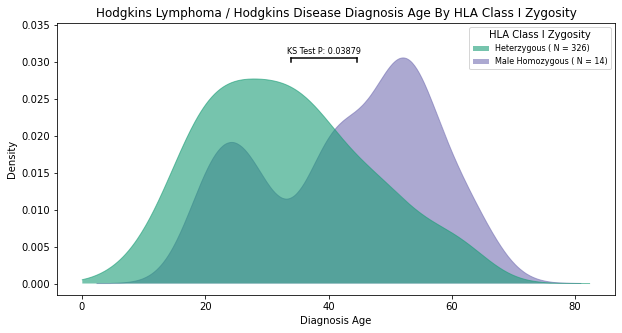

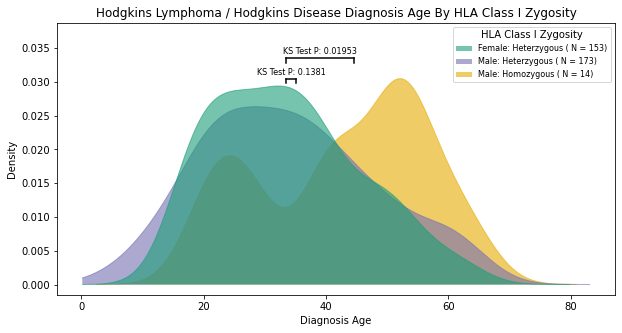

In [38]:
cancer = hodgkins_label

_, illness_dx_ages = get_illness_value_dx_age(biobank_data, cancer, "cancer_code")
illness_values = illness_dx_ages >= 0

male, zygosity = biobank_data["sex"] == "Male", biobank_data["zygosity"]
index = (male & (zygosity == 3)) | (zygosity == 0)
label_map = {0: "Heterzygous", 3: "Male Homozygous"}
params = dict(feature="cancer_code", hue_name="HLA Class I Zygosity", palette="custom_dark", clip=[0, None])

fig, ax = plt.subplots(figsize=(10, 5))
diagnosis_age_plot(biobank_data, cancer, variable="zygosity", index=index, label_map=label_map, ax=ax, **params)


variable = biobank_data["sex"] + ": " + biobank_data["zygosity"].apply({0: "Heterzygous", 3: "Homozygous"}.get)
fig, ax = plt.subplots(figsize=(10, 5))
diagnosis_age_plot(biobank_data, cancer, variable=variable, index=index, ax=ax, **params)

# Diagnosis Age Plots

In [39]:
viral_cancer_types = [
    'hodgkins lymphoma / hodgkins disease',
    'larynx/throat cancer',
    'stomach cancer',
    'anal cancer',
    'liver/hepatocellular cancer',
    'cancer of lip/mouth/pharynx/oral cavity',
    'nasal cavity cancer',
    'kaposis sarcoma',
    "cervical cancer"
]

In [40]:
viral_cancer_values = biobank_data["cancer_code"].isin(viral_cancer_types).values
biobank_data["cancer type"] = np.array(["Other", "Virus Associated"])[viral_cancer_values * 1]

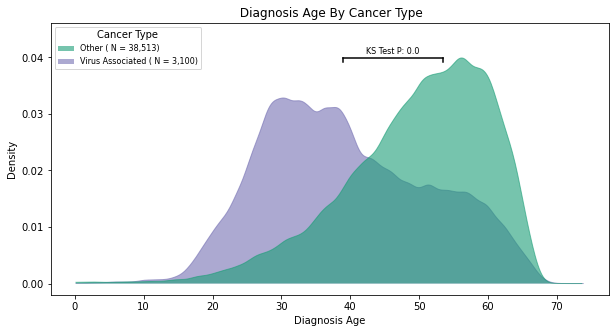

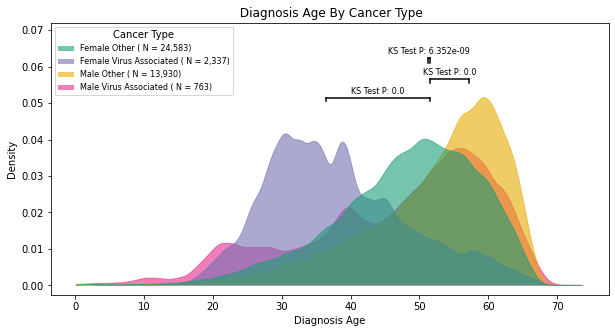

In [43]:
params = dict(feature="cancer code", alternative="two-sided", bw=0.08, clip=[0, None])

dx_ages = biobank_data["cancer_dx_age_interpolated"]
fig, ax = plt.subplots(figsize=(10, 5))
diagnosis_age_plot(biobank_data, dx_ages, variable="cancer type", ax=ax, **params)
plt.show()

variable = biobank_data["sex"] + " " + biobank_data["cancer type"]
fig, ax = plt.subplots(figsize=(10, 5))
diagnosis_age_plot(biobank_data, dx_ages, variable=variable, ax=ax, **params, hue_name="Cancer Type")
plt.show()

# Individual Cancer Epidemiology

In [64]:
other_data = biobank_data.loc[~biobank_data["cancer_code"].isin(viral_cancer_types)]
other_dx_ages = other_data["cancer_dx_age_interpolated"]
other_dx_ages = other_dx_ages[~pd.isnull(other_dx_ages)]

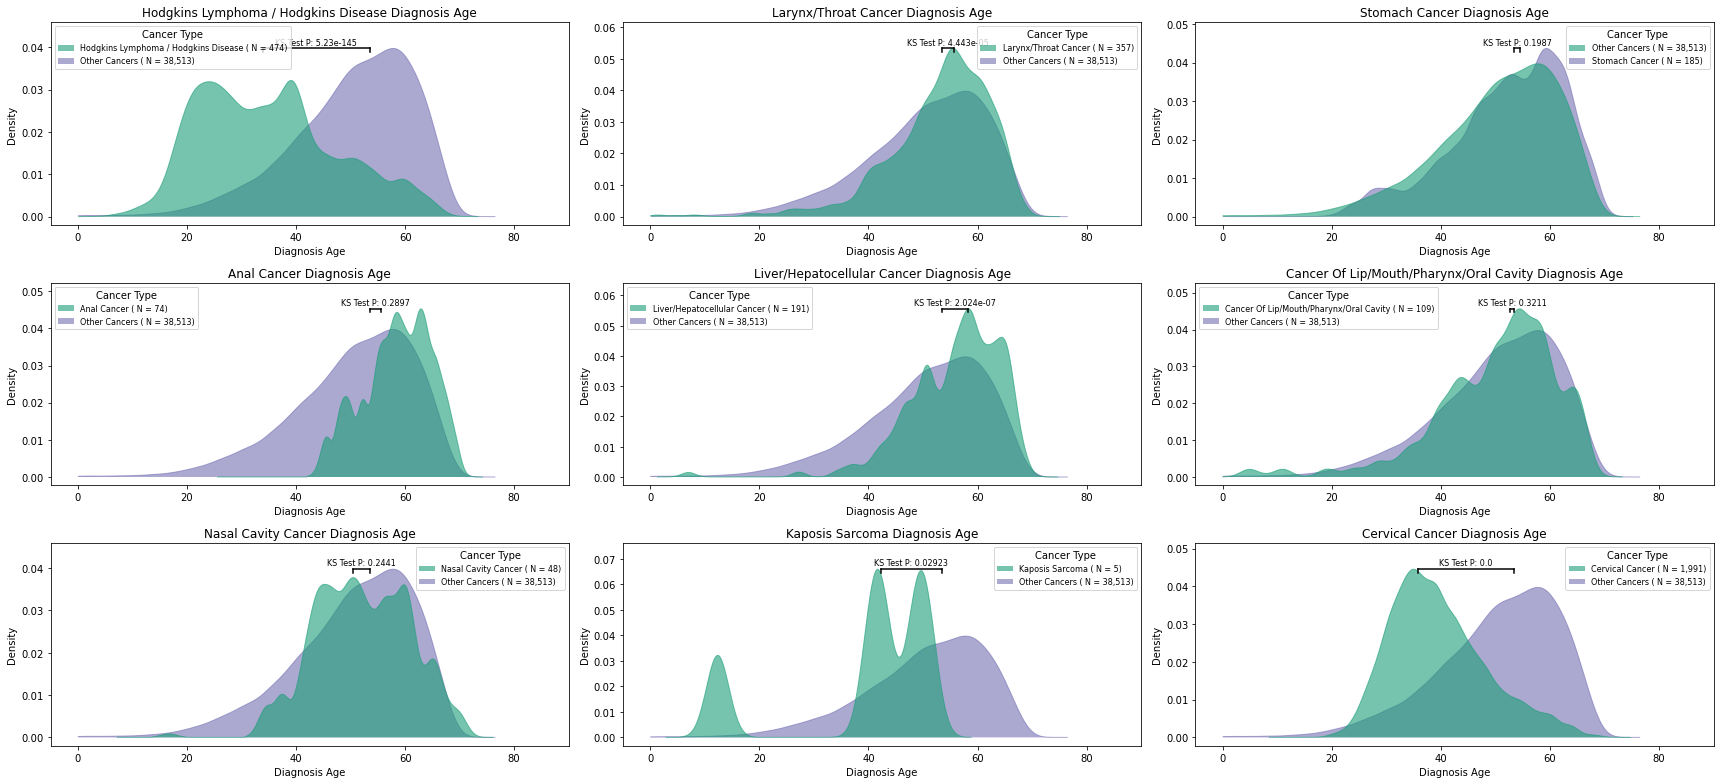

In [91]:
fig, axes = create_subplot(len(viral_cancer_types), ncols=3, height_per=3, width=24)

for ax, cancer_code in zip(axes, viral_cancer_types):
    _, cancer_dx_ages = get_illness_value_dx_age(biobank_data, cancer_code, "cancer_code")
    x_values = cancer_dx_ages[cancer_dx_ages > 0]
    hue_values = np.array([to_title(cancer_code)] * len(x_values) + ["Other Cancers"] * len(other_dx_ages))
    x_values = np.hstack([x_values, other_dx_ages])
#     kde_plot(x=x_values, hue=hue_values, ax=ax, bw=.1, clip=[0, None])

    params = dict(feature="cancer code", alternative="two-sided", bw=0.15, clip=[0, None])
    diagnosis_age_plot(biobank_data, x_values, variable=hue_values, ax=ax, **params, hue_name="Cancer Type")
    
    
    add_plt_labels(ax, x="Diagnosis Age", y="Density")
    ax.set_title(f"{to_title(cancer_code)} Diagnosis Age")
    ax.set_xlim(-5, 90)

fig.tight_layout()
fig.savefig(f"cancer_EDA_plots/cancer_dx_age_virus_associated_all.png")